In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import utils
from torchvision import datasets
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn


for dirpath, dirnames, filenames in os.walk('/Users/zachderse//Desktop/self_projects'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
train_dir = "/Users/zachderse//Desktop/self_projects/train"
test_dir = "/Users/zachderse//Desktop/self_projects/test"

train_dir, test_dir

There are 3 directories and 1 images in '/Users/zachderse//Desktop/self_projects'.
There are 2 directories and 1 images in '/Users/zachderse//Desktop/self_projects/Test'.
There are 0 directories and 22 images in '/Users/zachderse//Desktop/self_projects/Test/CDR_0'.
There are 0 directories and 5 images in '/Users/zachderse//Desktop/self_projects/Test/CDR_1'.
There are 2 directories and 1 images in '/Users/zachderse//Desktop/self_projects/Train'.
There are 0 directories and 71 images in '/Users/zachderse//Desktop/self_projects/Train/CDR_0'.
There are 0 directories and 12 images in '/Users/zachderse//Desktop/self_projects/Train/CDR_1'.
There are 0 directories and 1 images in '/Users/zachderse//Desktop/self_projects/.ipynb_checkpoints'.


('/Users/zachderse//Desktop/self_projects/train',
 '/Users/zachderse//Desktop/self_projects/test')

In [2]:
#checking the pixel values in a histogram to find if adjustments are needed
img = Image.open("/Users/zachderse//Desktop/self_projects/test/CDR_0/0323C_S.png")
img_np = np.array(img)
transform = transforms.Compose([
    transforms.ToTensor()
])
img_tr = transform(img)
img_tr = transform(img)
 

mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
 
#should be one dimension for the grayscale data
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.2802])
Std: tensor([0.3063])


Mean and Std of normalized image:
Mean: tensor([-1.9392e-07])
Std: tensor([1.0000])


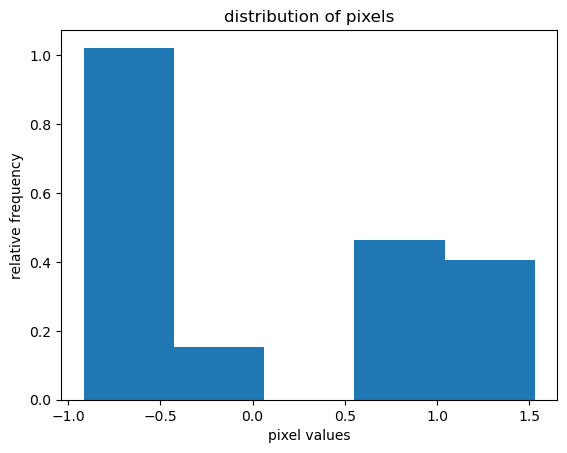

In [3]:
#checking the normalized histogram

transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
 
img_normalized = transform_norm(img)
img_np = np.array(img_normalized)
 
plt.hist(img_np.ravel(), bins=5, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

img_nor = transform_norm(img)
 

mean, std = img_nor.mean([1,2]), img_nor.std([1,2])
print("Mean and Std of normalized image:")
print("Mean:", mean)
print("Std:", std)

In [4]:
train_transforms = transforms.Compose([transforms.Resize((180,180)),
                                       transforms.ToTensor(),
                                       
                                       transforms.Normalize(mean, std)
                                      ])

test_transforms = transforms.Compose([transforms.Resize((180,180)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std) 
                                      ])

#datasets
train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

#check if the classes and images are expected
class_names = train_data.classes
print(class_names)
class_dict = train_data.class_to_idx
print(class_dict)
len(train_data), len(test_data)

['CDR_0', 'CDR_1']
{'CDR_0': 0, 'CDR_1': 1}


(82, 26)

In [5]:
def train_step(model, dataload, loss_fn, optimizer):
    #set model to train
    model.train()
    #reset loss and accuracy
    loss, acc = 0, 0
    
    for batch, (X, y) in enumerate(dataload):
        X, y = X.to('cpu'), y.to('cpu')
        
        y_pred = model(X)

        #y = y.unsqueeze(1)
        #y = y.float()
        loss = loss_fn(y_pred, y)
        
        
        loss += loss.item() 

                # Zero the gradient to remove previous optimizer data
        optimizer.zero_grad()
                # back propagation
        loss.backward()
                #step
        optimizer.step()
        

        # get accuracy metric across all batches
        y_pred_class = torch.argmax(torch.log_softmax(y_pred, dim=1), dim=1)
        acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    

    loss = loss / len(dataload)
    acc = acc / len(dataload)
    
    return loss, acc

In [6]:
def test_step(model, dataload, loss_fn: torch.nn.Module):
    # Switch to eval mode
    model.eval() 
    
    # Set loss and accuracy to zero
    loss, acc = 0, 0
    
    # Turn on inference 
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataload):
            X, y = X.to('cpu'), y.to('cpu')
            
            test_pred_logits = model(X)
            

            #y = y.unsqueeze(1)
            #y = y.float()
            loss = loss_fn(test_pred_logits, y)
            
            loss += loss.item()
            
            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # get average loss and accuracy per batch 
    loss = loss / len(dataload)
    acc = acc / len(dataload)
    return loss, acc

In [7]:
from tqdm.auto import tqdm
def train(model, optimizer, loss_fn, dataload_train, dataload_test, epochs):
    #initialize values
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}
    #do a test step for every epoch
    for i in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, dataload_train, loss_fn,optimizer)
        
        test_loss, test_acc = test_step(model, dataload_test, loss_fn)
        
        print(
                    f"Epoch: {i+1} | "
                    f"train_loss: {train_loss:.4f} | "
                    f"train_acc: {train_acc:.4f} | "
                    f"test_loss: {test_loss:.4f} | "
                    f"test_acc: {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [8]:


device = "cpu"
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

In [9]:
from torch.optim import lr_scheduler

#loss, unbalanced training set
loss_fn = nn.NLLLoss()
#reduction="sum"

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

results = train(model=model, optimizer=optimizer, loss_fn=loss_fn, dataload_train=trainloader, dataload_test=testloader, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: -0.5268 | train_acc: 0.0000 | test_loss: -0.7213 | test_acc: 0.0000
Epoch: 2 | train_loss: -1.4852 | train_acc: 0.2396 | test_loss: -2.8185 | test_acc: 0.0000
Epoch: 3 | train_loss: -2.4289 | train_acc: 0.4688 | test_loss: -4.6191 | test_acc: 0.0000
Epoch: 4 | train_loss: -3.3515 | train_acc: 0.7604 | test_loss: -7.1709 | test_acc: 0.3375
Epoch: 5 | train_loss: -3.3466 | train_acc: 0.7188 | test_loss: -10.8850 | test_acc: 0.5312
Epoch: 6 | train_loss: -5.1518 | train_acc: 0.8542 | test_loss: -14.4943 | test_acc: 0.7625
Epoch: 7 | train_loss: -6.0466 | train_acc: 0.8646 | test_loss: -16.1714 | test_acc: 0.6750
Epoch: 8 | train_loss: -6.9986 | train_acc: 0.8750 | test_loss: -19.3096 | test_acc: 0.8375
Epoch: 9 | train_loss: -7.9766 | train_acc: 0.8750 | test_loss: -22.8742 | test_acc: 0.8562
Epoch: 10 | train_loss: -8.8699 | train_acc: 0.8750 | test_loss: -26.5371 | test_acc: 0.8063
Epoch: 11 | train_loss: -9.7737 | train_acc: 0.8750 | test_loss: -29.9229 | test_ac

In [10]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728